In [2]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
# import os
# import sys
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt

# import warnings
# from tqdm import tqdm
# from time import time as clock

# from astropy.io import fits
# from wotan import flatten
# from astropy.stats import sigma_clip

# import utils

# import data_processing as dp
# from visualize import plot
# import lilith_utils
# from data.lilith.lilith_utils import *

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [3]:
import os
from dataloading import loading as dl
from lilith.lilith_utils import *

In [2]:
# download curl files and ground truth
# https://archive.stsci.edu/missions-and-data/tess/data-products/lilith-4

In [3]:
BASE_PATH = "data/lilith"
SECTOR = {i:f"/sector{i}" for i in [1,2,3,4]}  # use as: path = BASE_PATH + SECTOR[i]
[BASE_PATH + "/" + dirname for dirname in os.listdir(BASE_PATH) if os.path.isdir(BASE_PATH + "/" + dirname)]

['data/lilith/.ipynb_checkpoints',
 'data/lilith/sector1',
 'data/lilith/sector2',
 'data/lilith/sector3',
 'data/lilith/sector4',
 'data/lilith/test']

In [7]:
def get_data(load_path):
    # from fits file
    try:
        hdu = fits.open(load_path)
        time = hdu[1].data.TIME
        flux = hdu[1].data.PDCSAP_FLUX
        flux_err = hdu[1].data.PDCSAP_FLUX_ERR
        
        quality = hdu[1].data.QUALITY

        mom_col_centr = hdu[1].data.MOM_CENTR1
        mom_row_centr = hdu[1].data.MOM_CENTR2
    except:
        print(f"WARNING: no data found for {load_path.split('/')[-1]}")
        n = get_seq_length('/'.join(load_path.split('/')[:-1]))
        time = flux = flux_err = mom_col_centr = mom_row_centr = quality = np.zeros(n)*np.nan
    
    return time, flux, flux_err, mom_col_centr, mom_row_centr, quality

def get_seq_length(path_to_fits):
    # assuming same seq length for each lc in a sector
    for fname in os.listdir(path_to_fits):
        sampleid = sampleid_from_fname(fname)
        if sampleid is not None:
            seq_length = len(get_data(path_to_fits+"/"+fname)[0])
            break
    return seq_length
    
def save_efficient(path_to_fits, save_path, bsize=250):
    # load fits and save in pickled batches
    # make sure num fits % b(atch)size == 0
    to_save = len(sampleids_from_fits(path_to_fits))
    utils.make_dir(save_path)
    n = get_seq_length(path_to_fits)
    def _empty_arrays():
        arrays = (-np.ones((bsize,n)), -np.ones((bsize,n)), -np.ones((bsize,n)))
        arrays += (-np.ones((bsize,n)), -np.ones((bsize,n)), -np.ones((bsize,n)).astype(int))
        arrays += (-np.ones(bsize).astype(int),)
        return arrays
    def _get_batch_fname():
        return str(batches_done*bsize).zfill(5)+"-"+str(min(to_save-1,(batches_done+1)*bsize-1)).zfill(5)
    # arrays to save as b(atch)
    time, flux, flux_err, mom_col, mom_row, quality, sampleids = _empty_arrays()

    pbar = tqdm(os.listdir(path_to_fits))
    i, batches_done = 0, 0
    save_fname = _get_batch_fname()
    for fname in pbar:
        try: 
            sampleid = sampleid_from_fname(fname)
            if sampleid is not None:
                sampleids[i] = sampleid
                data = get_data(path_to_fits+"/"+fname)
                time[i], flux[i], flux_err[i], mom_col[i], mom_row[i], quality[i] = data
                i += 1
                if i == bsize or batches_done*bsize+i == to_save:
                    batches_done += 1
                    batch_data = {"time":time,"flux":flux,"flux_err":flux_err,
                                  "mom_col":mom_col,"mom_row":mom_row,"quality":quality,
                                  "sampleids":sampleids}
                    with open(save_path + "/" + save_fname, "wb") as f:
                        pickle.dump(batch_data, f)
                    save_fname = _get_batch_fname()
                    time, flux, flux_err, mom_col, mom_row, quality, sampleids = _empty_arrays()
                    i = 0
        except: 
            pbar.close()
            raise


def get_missing_curls(path_to_fits):
    # curl lines that did not get processed correctly during download
    # assuming bash (.sh) file is located in same dir as fits
    bash_file = get_bash_file(path_to_fits)
    fits_sampleids = sampleids_from_fits(path_to_fits)
    curl_sampleids = sampleids_from_curl(path_to_fits)
    missing_sampleids = np.setxor1d(fits_sampleids, curl_sampleids)
    missing_curls = []
    with open(path_to_fits+"/"+bash_file, "r") as f:
        lines = f.read().splitlines()
    for line in lines:
        if line.endswith(".fits.gz"):
            sampleid = sampleid_from_fname(line.split("/")[-1])
            if sampleid in missing_sampleids:
                missing_curls.append(line)
    return missing_curls

In [8]:
# sector = 1  # for all sectors, save efficient, then remove raw files
# sector_path = BASE_PATH + SECTOR[sector]
# save_efficient(sector_path+'/fits', sector_path+"/raw_batches", bsize=250)
# get_missing_curls(sector_path + "/fits")

In [9]:
# load ground-truth and sector sampleids
sampleids_sector = {i:sampleids_from_curl(BASE_PATH+SECTOR[i]+'/fits') for i in SECTOR}
sampleids = set()
for i in SECTOR:
    sampleids.update(sampleids_sector[i])
sampleids = np.array(list(sampleids))

gt_sector = {i:{obj:{} for obj in ["pl", "eb", "beb"]} for i in SECTOR}
gt = {obj:{"params":{}, "sampleids":[]} for obj in ["pl", "eb", "beb"]}
for i in SECTOR:
    gt_path = BASE_PATH+SECTOR[i]+'/ground_truth'
    gt_sector[i]["pl"]["params"], gt_sector[i]["pl"]["sampleids"] = get_pl_data(gt_path, sampleids_sector[i])
    gt_sector[i]["eb"]["params"], gt_sector[i]["eb"]["sampleids"] = get_eb_data(gt_path, sampleids_sector[i], backeb=0)
    gt_sector[i]["beb"]["params"], gt_sector[i]["beb"]["sampleids"] = get_eb_data(gt_path, sampleids_sector[i], backeb=1)
    for obj in ["pl", "eb", "beb"]:
        for sampleid, obj_data in gt_sector[i][obj]["params"].items():  
            if sampleid in gt[obj]["sampleids"]:
                # ground truth already saved from prev sector
                if obj_data != gt[obj]["params"][sampleid]:
                    print("WARNING: inconsistent ground-truth data")
            elif obj_data != {}:
                gt[obj]["params"][sampleid] = obj_data
                gt[obj]["sampleids"].append(sampleid)
for obj in ["pl", "eb", "beb"]:
    gt[obj]["sampleids"] = np.array(gt[obj]["sampleids"])
    for sampleid in sampleids:
        if sampleid not in gt[obj]["sampleids"]:
            gt[obj]["params"][sampleid] = {}

In [10]:
# select test samples and display statistics
test_sampleids = {obj:set() for obj in ["all", "pl", "eb", "beb"]}  # not to be used for training

print("sectors   inters  pl    eb   beb  pl+eb  pl+beb  pl+eb+beb".upper())
def _print_line(i, s_ids, pl_ids, eb_ids, beb_ids, spc=[3,3,2,2,2,6,5]):
    line = i+" "*spc[0] + str(len(s_ids)) +" "*spc[1]
    line += str(len(pl_ids))+" "*spc[2]+str(len(eb_ids))+" "*spc[3]+str(len(beb_ids))+" "*spc[4]
    line += str(len(np.intersect1d(pl_ids, eb_ids)))+" "*spc[5]
    line += str(len(np.intersect1d(pl_ids, beb_ids)))+" "*spc[6]
    line += str(len(np.intersect1d(np.intersect1d(pl_ids, eb_ids), beb_ids)))
    print(line)
    
def inter(a, b):
    return np.intersect1d(a, b)

# single
for i in SECTOR: 
    sec_str = " ".join([str(i) if (i==j) else ' ' for j in SECTOR])
    _print_line(sec_str, sampleids_sector[i], gt_sector[i]["pl"]["sampleids"], 
                gt_sector[i]["eb"]["sampleids"], gt_sector[i]["beb"]["sampleids"])
print()
# double
for i1 in SECTOR:
    for i2 in SECTOR:
        if i2 > i1:
            s_ids = inter(sampleids_sector[i1], sampleids_sector[i2])
            pl_ids = inter(gt_sector[i1]["pl"]["sampleids"], gt_sector[i2]["pl"]["sampleids"])
            eb_ids = inter(gt_sector[i1]["eb"]["sampleids"], gt_sector[i2]["eb"]["sampleids"])
            beb_ids = inter(gt_sector[i1]["beb"]["sampleids"], gt_sector[i2]["beb"]["sampleids"])
            
            test_sampleids["all"].update(s_ids), test_sampleids["pl"].update(pl_ids)
            test_sampleids["eb"].update(eb_ids), test_sampleids["beb"].update(beb_ids)
            
            sec_str = " ".join([str(i) if (i1==i or i2==i) else ' ' for i in SECTOR])
            _print_line(sec_str, s_ids, pl_ids, eb_ids, beb_ids, [3,4,2,2,2,6,6])
print()
# triple
for i1 in SECTOR:
    for i2 in SECTOR:
        for i3 in SECTOR:
            if i3 > i2 and i2 > i1:
                s_ids = inter(inter(sampleids_sector[i1], sampleids_sector[i2]), sampleids_sector[i3])
                pl_ids = inter(gt_sector[i1]["pl"]["sampleids"], gt_sector[i2]["pl"]["sampleids"])
                pl_ids = inter(pl_ids, gt_sector[i3]["pl"]["sampleids"])
                eb_ids = inter(gt_sector[i1]["eb"]["sampleids"], gt_sector[i2]["eb"]["sampleids"])
                eb_ids = inter(eb_ids, gt_sector[i3]["eb"]["sampleids"])
                beb_ids = inter(gt_sector[i1]["beb"]["sampleids"], gt_sector[i2]["beb"]["sampleids"])
                beb_ids = inter(beb_ids, gt_sector[i3]["beb"]["sampleids"])
                sec_str = " ".join([str(i) if (i1==i or i2==i or i3==i) else ' ' for i in SECTOR])
                if i1 == 1 and i2 == 2 and i3 == 3:
                    s_all = inter(s_ids, sampleids_sector[4])
                    pl_all = inter(pl_ids, gt_sector[4]["pl"]["sampleids"])
                    eb_all = inter(eb_ids, gt_sector[4]["eb"]["sampleids"])
                    beb_all = inter(eb_ids, gt_sector[4]["beb"]["sampleids"])
                _print_line(sec_str, s_ids, pl_ids, eb_ids, beb_ids, [3,4,3,2,2,6,6])
_print_line("\n1 2 3 4", s_all, pl_all, eb_all, beb_all, [3,4,3,2,3,6,7])
_print_line("\nTEST", test_sampleids["all"], test_sampleids["pl"], 
            test_sampleids["eb"], test_sampleids["beb"], [6,3,2,2,2,6,7])

SECTORS   INTERS  PL    EB   BEB  PL+EB  PL+BEB  PL+EB+BEB
1         16000   3146  900  871  0      192     0
  2       15998   3250  833  861  0      201     0
    3     15996   3173  818  861  0      189     0
      4   15997   3212  837  828  0      188     0

1 2       7261    1425  403  387  0      90      0
1   3     5500    1072  301  298  0      62      0
1     4   5489    1076  283  311  0      63      0
  2 3     7229    1430  377  381  0      92      0
  2   4   5458    1085  290  296  0      72      0
    3 4   7170    1411  373  399  0      94      0

1 2 3     4937    959   273  260  0      54      0
1 2   4   4633    908   249  254  0      53      0
1   3 4   4659    922   248  254  0      56      0
  2 3 4   4917    976   264  259  0      65      0

1 2 3 4   4153    817   225  10   0      0       0

TEST      12274   2420  634  678  0      0       0


In [8]:
# save test data separately
# for sector in [1,2,3]:
#     sector_path = BASE_PATH + SECTOR[sector]
#     utils.make_dir(sector_path + '/test_batches')
#     pbar = tqdm(os.listdir(sector_path+'/raw_batches'))
#     for fname in pbar:
#         try:
#             load_path = sector_path + '/raw_batches/' + fname
#             batch = load_data(load_path, unpack=False)
#             if batch is None:
#                 continue
#             test_sample = np.array([(s_id in test_sampleids['all']) for s_id in batch["sampleids"]])
#             for d in batch:
#                 batch[d] = batch[d][test_sample]
#             store_path = sector_path + '/test_batches/' + fname
#             with open(store_path, "wb") as f:
#                 pickle.dump(batch, f)
#         except:
#             pbar.close()
#             raise

In [9]:
# def get_lc(sampleid, sampleid2path=None):
#     if sampleid2path is None:
#         with open(BASE_PATH + "/sampleid2path.pkl", "rb") as f:
#             sampleid2path = pickle.load(f)
#     time, flux = [], []
#     for sector in [1,2,3]:
#         fname = sampleid2path[sampleid][sector-1]
#         if fname is None:
#             continue
#         batch = load_data(BASE_PATH + f"/sector{sector}/test_batches/" + fname, unpack=False)
#         indx = np.where(batch["sampleids"]==sampleid)[0]
#         if len(indx) > 1:
#             print("WARNING: multiple cases of same sampleid")
#         indx = indx[0]
#         time.append(batch["time"])
#         flux.append(batch["flux"])
#     return time, flux

In [10]:
# with open(BASE_PATH + "/sampleid2path.pkl", "rb") as f:
#     sampleid2path_ = pickle.load(f)
# sampleid2path = {i:[j for j in sampleid2path_[i]] for i in sampleid2path_}
# # keep only the test sampleids
# for s_id in sampleid2path_:
#     if s_id not in test_sampleids["all"]:
#         del sampleid2path[s_id]

In [12]:
# def _list2name(lst):
#     return " ".join(["-" if d is None else d for d in lst])

# def _name2list(name):
#     return [None if d=="-" else d for d in name.split(" ")]

# fnames_all = {}
# for s_id in sampleid2path:
#     name = _list2name(sampleid2path[s_id])
#     if name not in fnames_all:
#         fnames_all[name] = [s_id]
#     else:
#         fnames_all[name].append(s_id)

In [13]:
# bsize = 200
# batch_dic = {}
# success = 0
# batch_i, batches_done = 0, 0
# to_save = len(test_sampleids["all"])
# pbar = tqdm(fnames_all)
# for fnames_name in pbar:
#     fnames = _name2list(fnames_name)
#     batches = []
#     for i, fname in enumerate(fnames):
#         if fname is not None:
#             load_path = BASE_PATH+SECTOR[i+1]+"/raw_batches/"+fname
#             batches.append(load_data(load_path, unpack=False))
            
#     for sampleid in fnames_all[fnames_name]:
#         if sampleid in batch_dic:
#             print("WARNING: sampleid added twice to batch_dic!")
#         indc = [np.where(batch["sampleids"]==sampleid)[0][0] for batch in batches]
#         batch_dic[sampleid] = {"time":[batch["time"][indc[j]] for j,batch in enumerate(batches)],
#                                "flux":[batch["flux"][indc[j]] for j,batch in enumerate(batches)]}
#         batch_i += 1
#         if batch_i == bsize or batches_done*bsize+batch_i == to_save:
#             fname = str(batches_done*bsize).zfill(5)+"-"+str(min(to_save-1,(batches_done+1)*bsize-1)).zfill(5)
#             success += len(batch_dic)
#             with open(BASE_PATH + "/test/" + fname, "wb") as f:
#                 pickle.dump(batch_dic, f)
#             batch_dic = {}
#             batch_i = 0
#             batches_done += 1

In [14]:
# # save: test sampleid to fname in sector path
# testid2path = {}
# pbar = tqdm(os.listdir(BASE_PATH + "/test/"))
# for fname in pbar:
#     if fname.startswith("."):
#         continue
#     batch = load_data(BASE_PATH + "/test/" + fname, unpack=False)
#     for sampleid in batch:
#         testid2path[sampleid] = fname
# with open(BASE_PATH + "/testid2path.pkl", "wb") as f:
#     pickle.dump(testid2path, f)

In [15]:
# # save: sampleid to fname in sector path
# sampleid2path = {i:[None,None,None] for i in np.union1d(np.union1d(sampleids[1], sampleids[2]), sampleids[3])}
# for sector in [1,2,3]:
#     sector_path = BASE_PATH + SECTOR[sector]
#     pbar = tqdm(os.listdir(sector_path+'/raw_batches'))
#     for fname in pbar:
#         try:
#             load_path = sector_path + '/raw_batches/' + fname
#             batch = load_data(load_path, unpack=False)
#             if batch is None:
#                 continue
#             for sampleid in batch["sampleids"]:
#                 sampleid2path[sampleid][sector-1] = fname  
#         except:
#             pbar.close()
#             raise
# with open(BASE_PATH + "/sampleid2path.pkl", "wb") as f:
#     pickle.dump(sampleid2path, f)

In [9]:
def split_lightcurve(time, data, size=1500, step=344, leftover=20, info=False):
    # each time a window of "size" is stored and shifted by "step", such that less
    # than "leftover" points are left unused
    data = data if isinstance(data, list) else [data]
    
    options = np.arange(1,size+1)  # assuming step <= size
    options = options[np.where((len(time)-size) % options <= leftover)[0]]
    best_choice = options[np.abs(options-step).argmin()]
    if step != best_choice:
        print(f"Choosing step = {best_choice} (instead of = {step})") if info else 0
        step = best_choice
    
    time_segments = np.array([time[i:i+size] for i in range(0,len(time),step) if i+size <= len(time)])
    data_segments = []
    for d in data:
        data_segments.append(np.array([d[i:i+size] for i in range(0,len(time),step) if i+size <= len(time)]))
    
    if info:
        not_used = np.sum(time>time[np.where(time == time_segments[-1][-1])[0]])
        print(f"{not_used} data points left unused")
    
    return time_segments, data_segments


def evaluate_segments(data_seg, depth_range=(0.25,10), snr_range=(3,1e9), duration_range=(0,utils.hour2day(14))):
    # returns boolean array of rejections
    n_range = [int(dur/utils.min2day(2)) for dur in duration_range]
    
    # unpack data
    flux_seg, mask_seg, overlap_seg = data_seg["flux"], data_seg["mask"], data_seg["overlap"]
    depth_seg, n_seg = data_seg["rdepth"], data_seg["tr_n"]
    
    # first or last timestep nan - later added for NN training
    edge_nan = np.isnan(flux_seg[:,0]) | np.isnan(flux_seg[:,-1])
    
    # general transit selection
    transit = np.any(mask_seg, axis=1)
    edge_transit = mask_seg[:,0] | mask_seg[:,-1]
    overlap = np.any(overlap_seg, axis=1)  # dont allow transit overlap (could allow)
    too_shallow = np.any((depth_seg > 0) & (depth_seg < depth_range[0]), axis=1)
    too_deep = np.any(depth_seg > depth_range[1], axis=1)
    too_short = np.any((n_seg > 0) & (n_seg < n_range[0]), axis=1)
    too_long = np.any(n_seg > n_range[1], axis=1)

    rejected = edge_nan | edge_transit | overlap | too_shallow | too_deep | too_short | too_long
    
    # specific transit selection
    for i in range(len(flux_seg)):
        if transit[i] and not rejected[i]:
            flux_i, mask_i, depth_i, n_i = flux_seg[i], mask_seg[i], depth_seg[i], n_seg[i]
            tr_indc = dp.separate_trues(mask_i)
            for indc in tr_indc:
                if len(np.unique(n_i[indc]))!=1 or len(np.unique(depth_i[indc]))!=1:
                    # this happens if transits are touching, but not overlapping
                    rejected[i] = True
#                     print("WARNING: transit indices do not correspond to transit parameter segment!")
                    continue
                n_true = n_i[indc][0]  # theoretical number of transit cadences
                n_data = len(indc) - np.isnan(flux_i[indc]).sum()
                # if transit is less than half visible or snr >/< threshold, reject
                snr_eff = depth_i[indc][0] * np.sqrt(n_data)
                if n_data < n_true/2. or snr_eff < snr_range[0] or snr_eff > snr_range[1]:
                    rejected[i] = True
    return rejected

In [10]:
#TESS Science Data Products Description Document (EXP-TESS-ARC-ICD-0014)
#https://archive.stsci.edu/missions/tess/doc/EXP-TESS-ARC-ICD-TM-0014.pdf
# code from lightkurve.TessQualityFlags
AttitudeTweak, SafeMode = 1, 2
CoarsePoint, EarthPoint = 4, 8
Argabrightening, Desat = 16, 32
ApertureCosmic, ManualExclude = 64, 128 
Discontinuity, ImpulsiveOutlier = 256, 512
CollateralCosmic = 1024
#: The first stray light flag is set manually by MIT based on visual inspection.
#: The second stray light flag is set automatically by Ames/SPOC based on background level thresholds.
Straylight, Straylight2 = 2048, 4096

#: DEFAULT bitmask identifies all cadences which are definitely useless.
DEFAULT_BITMASK = (AttitudeTweak | SafeMode | CoarsePoint | EarthPoint |
                   Desat | ManualExclude)

In [12]:
# np.random.seed(42)
# for sector in [1,2,3,4]:
#     sector_path = BASE_PATH + SECTOR[sector]

#     seg_size = 1500
#     raw_path = sector_path+'/raw_batches'
#     processed_path = sector_path+'/processed_batches'
#     utils.make_dir(processed_path)

#     batch_dnames = ["flux", "mask", "rdepth", "mom_col", "mom_row"]
#     def _get_empty_seg_dic():
#         data_dic = {d:np.zeros((0, seg_size)) for d in batch_dnames}
#         data_dic["mask"] = data_dic["mask"].astype(bool)
#         data_dic["sigma"] = np.zeros(0)
#         return data_dic

#     pbar = tqdm(os.listdir(raw_path))
#     for fname in pbar:
#         try:
#             batch = dp.load_data(raw_path+"/"+fname, unpack=["time","flux","mom_col","mom_row",
#                                                              "quality","sampleids"])
#             time_all, flux_all, mom_col_all, mom_row_all, q_all, batch_ids = batch
#             if time_all is None:
#                 continue
                
#             # apply quality mask (remove flagged cadences)
#             q_msk = (q_all & DEFAULT_BITMASK) > 0
#             time_all[q_msk] = np.nan

#             # boolean array of samples with negative flux
#             neg_flux = np.any(flux_all < 0, axis=1)

#             # flag eb sampleids
#             eb_union = np.union1d(gt_sector[sector]["eb"]["sampleids"], 
#                                   gt_sector[sector]["beb"]["sampleids"])
#             eb_sample = np.array([(s_id in eb_union) for s_id in batch_ids])

#             # flag test samples
#             test_sample = np.array([(s_id in test_sampleids['all']) for s_id in batch_ids])

#             # exclude neg flux and eb samples and test samples
#             keep = ~(neg_flux | eb_sample | test_sample)
#             time_all, flux_all = time_all[keep], flux_all[keep]
#             mom_col_all, mom_row_all, batch_ids = mom_col_all[keep], mom_row_all[keep], batch_ids[keep]

#             # remove elements where flux==0 or time==nan
#             time_all[flux_all==0] = np.nan
#             nans_all = np.isnan(time_all)
#             flux_all[nans_all] = np.nan

#             # median normalize flux
#             flux_median = np.nanmedian(flux_all, 1)
#             flux_all = flux_all/flux_median[:,None]

#             # center centroids
#             mom_col_all = (mom_col_all - np.nanmean(mom_col_all, 1)[:,None])
#             mom_row_all = (mom_row_all - np.nanmean(mom_row_all, 1)[:,None])

#             data_final = _get_empty_seg_dic()

#             # make each sample uniform in time, then split and select
#             for i, sampleid in enumerate(batch_ids):
#                 if i % 50 == 0:
#                     data_accept = _get_empty_seg_dic()

#                 # remove nan values and index arrays
#                 nans = nans_all[i]
#                 time, flux = time_all[i][~nans], flux_all[i][~nans] 
#                 mom_col, mom_row = mom_col_all[i][~nans], mom_row_all[i][~nans]

#                 # clip outliers from flattened lc (small window so we dont clip out transits)
#                 flat = flatten(time, flux, method="median", window_length=utils.min2day(30))
#                 with warnings.catch_warnings():
#                     warnings.simplefilter("ignore")
#                     clip = sigma_clip(flat, sigma_lower=6, sigma_upper=6).mask
#                 time, flux = time[~clip], flux[~clip]
#                 mom_col, mom_row = mom_col[~clip], mom_row[~clip]
#                 sigma_est = np.std(flat[~clip])
                
#                 # low-risk flattening -- to make sure nn input has better range
#                 flux = flatten(time, flux, method="median", window_length=4)

#                 # make uniform (~2 min cadence), and fill in "nan" data values for new time steps
#                 time, (flux, mom_col, mom_row) = dp.uniform_time(time, [flux, mom_col, mom_row])

#                 # create transit masks and label time steps using transit params (for splitting)
#                 pl_masks, mask, overlap, rdepth, tr_n = get_transit_masks(time, 
#                                                             gt_sector[sector]["pl"]["params"][sampleid], 
#                                                             sigma_est, incl_params=True)

#                 # split lc into segments
#                 dnames = batch_dnames + ["overlap", "tr_n"]
#                 data = [eval(d) for d in dnames]
#                 time_seg, data_seg = split_lightcurve(time, data, size=seg_size, step=509, info=0)
#                 data_seg = {d:data_seg[di] for di, d in enumerate(dnames)}

#                 # filter segments
#                 rejected = evaluate_segments(data_seg, depth_range=(0.25,10), snr_range=(3,1e9), 
#                                              duration_range=(0,utils.hour2day(14)))
#                 for d in data_accept:
#                     if d == "sigma":
#                         data_accept[d] = np.concatenate((data_accept[d], sigma_est*np.ones((~rejected).sum())))
#                     else:
#                         data_accept[d] = np.vstack((data_accept[d], data_seg[d][~rejected]))

#                 if (i+1) % 50 == 0 or (i+1) == len(batch_ids):
#                     tr = data_accept["mask"].any(1)
#                     non_tr = np.random.choice(np.where(~tr)[0], size=tr.sum(), replace=False)
#                     for d in data_accept:
#                         if d == "sigma":
#                             balanced = np.concatenate((data_accept[d][tr], data_accept[d][non_tr]))
#                             data_final[d] = np.concatenate((data_final[d], balanced))
#                         else:
#                             balanced = np.vstack((data_accept[d][tr], data_accept[d][non_tr]))
#                             data_final[d] = np.vstack((data_final[d], balanced))
#             # save data_final
#             with open(processed_path+"/"+fname, "wb") as f:
#                 pickle.dump(data_final, f)

#         except:
#             pbar.close()
#             raise

In [29]:
np.array([38, 13, 13]) / 64

array([0.59375 , 0.203125, 0.203125])

In [30]:
splitsizes = [38, 13, 13]
splitnames = ["train", "valid", "test"]
dnames = ["flux", "mask", "rdepth", "mom_col", "mom_row", "sigma"]

for sector in [1,2,3,4]:
    sector_path = BASE_PATH + SECTOR[sector]
    store_path = sector_path+"/nn_dsets/flattened"
    utils.make_dir(store_path)
    bfnames = np.array([fnm for fnm in os.listdir(sector_path+"/processed_batches") if not fnm.startswith(".")])
    np.random.seed(42), np.random.shuffle(bfnames)
    
    for split_i, split in enumerate(splitnames):
        splitdata = {d:[] for d in dnames}
        start = sum(splitsizes[:split_i])
        pbar = tqdm(bfnames[start:start+splitsizes[split_i]])
        for fname in pbar:
            try:
                with open(sector_path+"/processed_batches/"+fname, "rb") as f:
                    batch = pickle.load(f)
                for d in dnames:
                    splitdata[d].append(batch[d])
            except:
                pbar.close()
                raise
        for d in dnames:
            if d == "sigma":
                splitdata[d] = np.concatenate(splitdata[d])
            else:
                splitdata[d] = np.vstack(splitdata[d])
        splitdata["transit"] = splitdata["mask"].any(1)
        with open(store_path + "/" + split, "wb") as f:
            pickle.dump(splitdata, f)

  0%|          | 0/38 [00:00<?, ?it/s]

Making directory 'data/lilith/sector1/nn_dsets/flattened'


  0%|          | 0/38 [00:00<?, ?it/s]

Making directory 'data/lilith/sector2/nn_dsets/flattened'


  3%|▎         | 1/38 [00:00<00:03,  9.74it/s]

Making directory 'data/lilith/sector3/nn_dsets/flattened'


  5%|▌         | 2/38 [00:00<00:02, 12.79it/s]

Making directory 'data/lilith/sector4/nn_dsets'
Making directory 'data/lilith/sector4/nn_dsets/flattened'


100%|██████████| 13/13 [00:01<00:00, 12.86it/s]


In [16]:
def get_lilith_dsets(sectors=None):
    splitnames = ["train", "valid", "test"]
    dnames = ["flux", "mask", "rdepth", "mom_col", "mom_row", "flux_err", "sigma", "transit"]
    combined = {s:{d:[] for d in dnames} for s in splitnames}
    
    if sectors is None:
        sectors = [1,2,3]
    if not isinstance(sectors, list):
        sectors = [sectors]
    for s in splitnames:
        for sector in sectors:
            sector_path = BASE_PATH + SECTOR[sector]
            load_path = sector_path + "/nn_dsets/" + s
            with open(load_path, "rb") as f:
                split = pickle.load(f)
            for d in dnames:
                combined[s][d].append(split[d])
        for d in dnames:
            combined[s][d] = np.concatenate(combined[s][d], axis=0)
    return combined

In [16]:
combined = get_lilith_dsets([1,2,3])

In [17]:
split = "train" 
rdepths, durations = [], []
pbar = tqdm(range(len(combined[split]["flux"])))
for i in pbar:
    try:
        if combined[split]["transit"][i]:
            tr_indc = dp.separate_trues(combined[split]["mask"][i])
            for indc in tr_indc:
                durations.append(len(indc)*utils.min2day(2))
                rdepths.append(combined[split]["rdepth"][i][indc[0]])
    except:
        pbar.close()
        raise
rdepths, durations = np.array(rdepths), np.array(durations)

100%|██████████| 34816/34816 [00:01<00:00, 18061.99it/s]


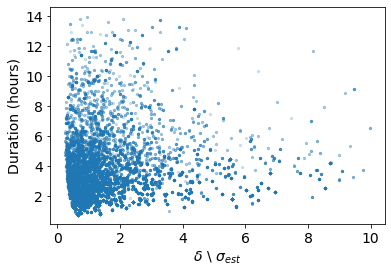

In [18]:
plt.scatter(rdepths, durations*24, s=5, alpha=0.2)
plt.xlabel("$\delta$ \ $\sigma_{est}$", fontsize=14)
plt.ylabel("Duration (hours)", fontsize=14)
plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.show()

## Planet parameter distributions

In [27]:
# "stretch" because the lists don't correspond to sampleids anymore
pl_stats = {s:[] for s in ["ror_stretch", "depth_stretch", "duration_stretch", "orb_period_stretch"]}
lc_stats = {**lc_stats, **{s+"_stretch":[] for s in lc_stats}}
for i, sampleid in enumerate(sampleids):
    for pl in pl_data[sampleid]:
        for s in ["ror", "depth", "duration", "orb_period"]:
            pl_stats[s+"_stretch"].append(pl_data[sampleid][pl][s])
        for s in lc_statnames:
            lc_stats[s+"_stretch"].append(lc_stats[s][i])
for s in pl_stats:
    pl_stats[s] = np.array(pl_stats[s])
for s in lc_stats:
    lc_stats[s] = np.array(lc_stats[s])

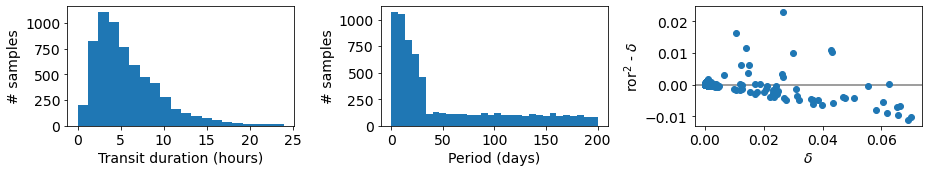

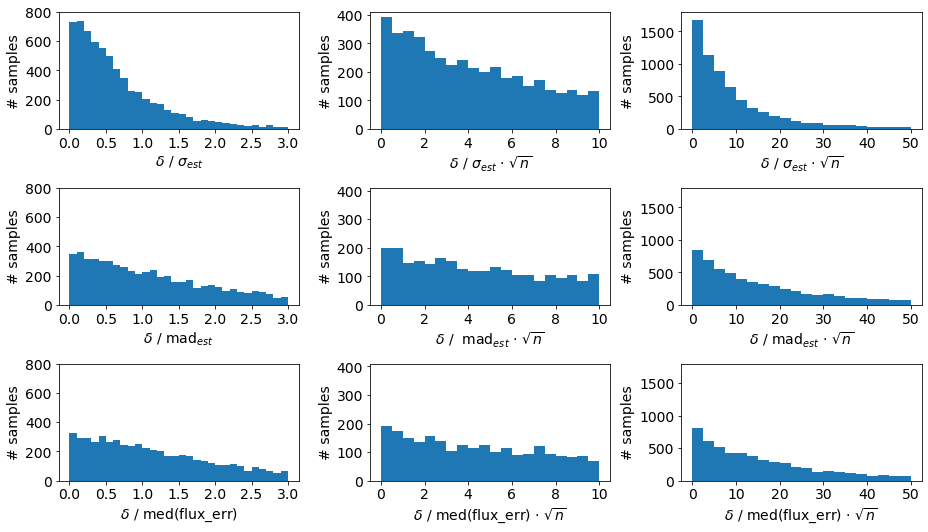

In [321]:
def plot_hist(data_array, lims=None, bins=20, xlbl="", title="", histtype="bar", labels=None): 
    plt.hist(data_array, range=lims, bins=bins, histtype=histtype, label=labels)
    plt.title(title, fontsize=14)
    plt.xlabel(xlbl, fontsize=14)
    plt.ylabel("# samples", fontsize=14)
    plt.xticks(fontsize=14), plt.yticks(fontsize=14)
    

plt.figure(figsize=(13,2.5))
plt.subplot(1,3,1)
plot_hist(pl_stats["duration_stretch"]*24, (0,24), 20, "Transit duration (hours)")

plt.subplot(1,3,2)
plot_hist(pl_stats["orb_period_stretch"], (0,200), 30, "Period (days)")

plt.subplot(1,3,3)
plt.scatter(pl_stats["depth_stretch"], pl_stats["ror_stretch"]**2-pl_stats["depth_stretch"])
plt.axhline(0, color="black", alpha=0.5, zorder=0)
plt.xlabel("$\delta$", fontsize=14), plt.ylabel("ror$^2$ - $\delta$", fontsize=14)
plt.xticks(fontsize=14), plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

w, h = 3, 3
ylims1 = (0,800)
ylims2 = (0,410)
ylims3 = (0,1800)
bins=20
plt.figure(figsize=(13, h*2.5))
n = pl_stats["duration_stretch"] / (2./60/24)

plt.subplot(h,w,1)
plt.ylim(ylims1[0], ylims1[1])
d_over_s = pl_stats["depth_stretch"]/lc_stats["std_est_stretch"]
plot_hist(d_over_s, (0,3), 30, "$\delta$ / $\sigma_{est}$")
plt.subplot(h,w,2)
plt.ylim(ylims2[0], ylims2[1])
plot_hist(d_over_s * np.sqrt(n), (0,10), bins, "$\delta$ / $\sigma_{est}$ $\cdot$ $\sqrt{n}$")
plt.subplot(h,w,3)
plt.ylim(ylims3[0], ylims3[1])
plot_hist(d_over_s * np.sqrt(n), (0,50), bins, "$\delta$ / $\sigma_{est}$ $\cdot$ $\sqrt{n}$")

plt.subplot(h,w,4)
plt.ylim(ylims1[0], ylims1[1])
d_over_s = pl_stats["depth_stretch"]/lc_stats["mad_est_stretch"]
plot_hist(d_over_s, (0,3), 30, "$\delta$ / mad$_{est}$")
plt.subplot(h,w,5)
plt.ylim(ylims2[0], ylims2[1])
plot_hist(d_over_s * np.sqrt(n), (0,10), bins, "$\delta$ /  mad$_{est}$ $\cdot$ $\sqrt{n}$")
plt.subplot(h,w,6)
plt.ylim(ylims3[0], ylims3[1])
plot_hist(d_over_s * np.sqrt(n), (0,50), bins, "$\delta$ / mad$_{est}$ $\cdot$ $\sqrt{n}$")

plt.subplot(h,w,7)
d_over_s = pl_stats["depth_stretch"]/lc_stats["err_med_stretch"]
plt.ylim(ylims1[0], ylims1[1])
plot_hist(d_over_s, (0,3), 30, "$\delta$ / med(flux_err)")
plt.subplot(h,w,8)
plt.ylim(ylims2[0], ylims2[1])
plot_hist(d_over_s * np.sqrt(n), (0,10), bins, "$\delta$ / med(flux_err) $\cdot$ $\sqrt{n}$")
plt.subplot(h,w,9)
plt.ylim(ylims3[0], ylims3[1])
plot_hist(d_over_s * np.sqrt(n), (0,50), bins, "$\delta$ / med(flux_err) $\cdot$ $\sqrt{n}$")

plt.tight_layout()
plt.show()

In [225]:
batch_size = 500
pbar = tqdm(range(int(16000 / batch_size)))
for i in pbar:
    load_fname = str(i*batch_size).zfill(5)+"-"+str((i+1)*batch_size-1).zfill(5)
    with open(PATH_LILITH+"/pickles/raw_batches/"+load_fname, "rb") as f:
        batch = pickle.load(f)
    break
pbar.close()

  0%|          | 0/32 [00:01<?, ?it/s]


In [ ]:
save_size=500


for i in pbar:
    try:
        batch_dict = {}
        
        for array in ["time", "flux", "flux_err", "mom_col", "mom_row"]:
            load_fname = array+"_"+str(i*save_size).zfill(5)+"-"+str((i+1)*save_size-1).zfill(5)
            with open(PATH_LILITH+"/pickles/raw_batches/"+array+"/"+load_fname, "rb") as f:
                data_array = pickle.load(f)
                batch_dict[array] = data_array
        batch_dict["sampleids"] = sampleids[i*save_size:(i+1)*save_size] 
        with open(PATH_LILITH+"/pickles/raw_batches/"+save_fname, "wb") as f:
            pickle.dump(batch_dict, f)
    except:
        pbar.close()
        raise

In [69]:
# with open(PATH_LILITH + "/pickles/nn_dsets/d1/train", "rb") as f:
#     train = pickle.load(f)
with open(PATH_LILITH + "/pickles/nn_dsets/d1/valid", "rb") as f:
    valid = pickle.load(f)

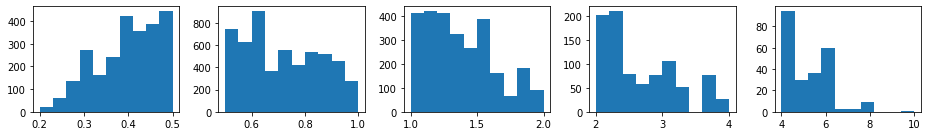

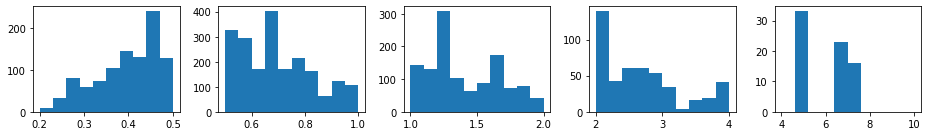

In [75]:
bins=10
for dset in [train, valid]:
    tr = dset["mask"].any(1) 
    plt.figure(figsize=(13,2))
    for i, rng in enumerate([(0.2,0.5),(0.5,1),(1,2),(2,4),(4,10)], 1):
        plt.subplot(1,5,i)
        plt.hist(np.max(dset["rel_depth"][tr], axis=1), bins=bins, range=rng)
    plt.tight_layout()
    plt.show()

In [157]:
dset = train
tr = dset["mask"].any(1)
lens = []
pbar = tqdm(range(len(dset["flux"][tr])))
for i in pbar:
    try:
        indc = dp.separate_trues(dset["mask"][tr][i])
        lens.append([len(idc) for idc in indc])
    except:
        pbar.close()
        raise

100%|██████████| 11775/11775 [01:44<00:00, 112.39it/s]


In [ ]:
dl.load("")

In [266]:
i = 8

fname = os.listdir("data/lilith/sector1/raw_batches")[i]
print(fname)

01750-01999


In [267]:
batch = dl.load_data("data/lilith/sector1/raw_batches/"+fname)

In [14]:
batch.keys()

dict_keys(['time', 'flux', 'flux_err', 'mom_col', 'mom_row', 'quality', 'sampleids'])

In [268]:
flux = batch["flux"] / np.nanmedian(batch["flux"], 1)[:,None]

In [269]:
AttitudeTweak, SafeMode = 1, 2
CoarsePoint, EarthPoint = 4, 8
Argabrightening, Desat = 16, 32
ApertureCosmic, ManualExclude = 64, 128 
Discontinuity, ImpulsiveOutlier = 256, 512
CollateralCosmic = 1024
#: The first stray light flag is set manually by MIT based on visual inspection.
#: The second stray light flag is set automatically by Ames/SPOC based on background level thresholds.
Straylight, Straylight2 = 2048, 4096

#: DEFAULT bitmask identifies all cadences which are definitely useless.
DEFAULT_BITMASK = (AttitudeTweak | SafeMode | CoarsePoint | EarthPoint |
                   Desat | ManualExclude)
qmsk = (batch["quality"] & DEFAULT_BITMASK) > 0
flux[qmsk] = np.nan
flux[np.isnan(batch["time"])] = np.nan

In [270]:
mx = np.nanmax(flux,1)

np.argmax(mx)

104

In [301]:
i += 1
nan = np.isnan(flux[i])
f_, trend = flatten(batch["time"][i], flux[i], method="savgol",
                    window_length=2881,  return_trend=1, cval=2)

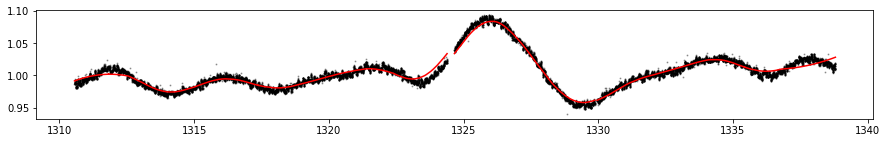

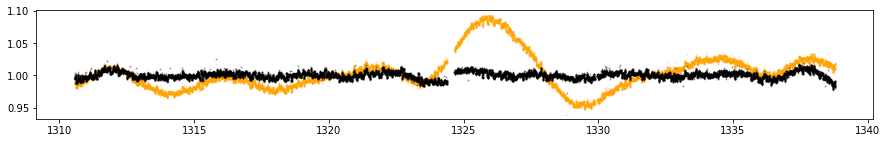

In [302]:
plt.figure(figsize=(15,2))
plt.scatter(batch["time"][i], flux[i], s=1, color="black", alpha=0.3)
plt.plot(batch["time"][i], trend, color="red")

plt.figure(figsize=(15,2))
plt.scatter(batch["time"][i], flux[i], s=1, color="orange", alpha=0.2)
plt.scatter(batch["time"][i], f_, s=1, color="black", alpha=0.3)

In [71]:
4 * 24 * 60 / 2

2880.0